# Project 2 Behavioral Cloning

### Exploratory Data Analysis of Training Data
 I initially started with creating small training data and the Comma.ai model to "bootstrap" the implementation and get started. By training initial patches, I was able to troubleshoot fundamental issues like reading in training data, modifying drive.py and getting the car to start driving.
 
 Udacity was kind enough to provide training data. This was a tremendous assist and an important lesson.
 
The lesson being that quality of training data is critical for the success of the model and collecting good data is by itself a major part of the endeavor and a challenge unto itself.
Let us first analyze the distribution of steering angles in the original training data.As we see from the histogram the distribution is skewed toward close to 0 steering angles.While this is expected as the driver is mostly driving in a straight line, it does not lend itself to sufficient training data to build a robust behavioral cloning model that will be able to apply the necessary correction in real-life circumstances. 

In [ ]:
import os
import argparse
import json
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

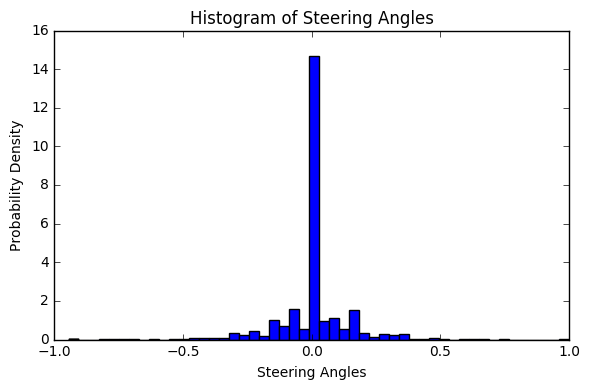

In [48]:
data_dir = "./data"
csv_file_name = os.path.join(data_dir, "driving_log.csv")
df = pd.read_csv(csv_file_name)

df_aray = df.values
X_center = df_aray[:, 0]
y_center = df_aray[:, 3]

num_bins = 50
fig, ax = plt.subplots()
n, bins, patches = ax.hist(y_center, num_bins, normed=1)
ax.set_xlabel('Steering Angles')
ax.set_ylabel('Probability Density')
ax.set_title('Histogram of Steering Angles')
fig.tight_layout()
plt.show()

## Left and Right Camera 

As was discussed in the Nvidia paper, and explained described in the assignment, we can leverage the images from the left and right cameras on the vehicle to additionally map recovery paths when the car is off-center. The steering angles associated with the left camera is obtained by adding offset +0.25 to the steering angle associated with the central camera. For the right camera the steering offset added is -0.25. The choice of 0.25 is based on trial and error and aligns with the Discussion Group's recommendations of 0.27, around 0.3. Let us see what the augmented training data's steering angle distribuion is with the addition of the left and right cameras.

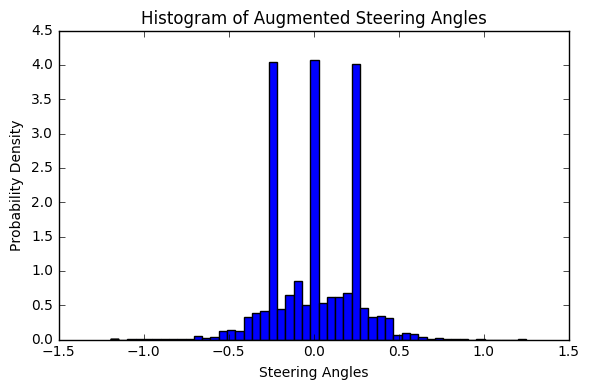

In [20]:
LEFT_STEERING_CORRECTION = 0.25
RIGHT_STEERING_CORRECTION = -0.25
y_left = df_aray[:, 3] + LEFT_STEERING_CORRECTION
y_right = df_aray[:, 3] + RIGHT_STEERING_CORRECTION
y = np.concatenate((y_center, y_left, y_right))
num_bins = 50
fig, ax = plt.subplots()
n, bins, patches = ax.hist(y, num_bins, normed=1)
ax.set_xlabel('Steering Angles')
ax.set_ylabel('Probability Density')
ax.set_title('Histogram of Augmented Steering Angles')
fig.tight_layout()
plt.show()

We expected three peaks but we also see a more spread out distribution of the different steering angles than before. While the additional camera images and corresponding recovery steering angles augment the training data and helps train the car when it is off center, as the above distribution indicates - for a robust model we need additional training data to train the car to detect curves in different brightness conditions and differents location when the car is off-center.    

## Image Preparation, Normalization and Augmentation

For discussion on image normalization please refer to the Model section below.

The goal of Image Augmentation is to create additional training data that will help it be robust to different brightness conditions and different recovery locations. So take existing images with their corresponding steering angles and then apply the different transformations of brightness correction, image translation and horizontal flip. 

I initially leveraged the keras pre-processing image library to create a generator function that would invoke their available transformations. However I ran into issues with applying the keras library image transformations to generate applicable augmentations. I came across an excellent blog-post by Vivek Yadav on[ Using Augmentation to mimic human driving ](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.yh93soib0) . He very nicely explained the how to apply brightness correction, image translations and horizontal flip to augment the data

Let us first see how I pre-process the image and investigate each of these image transformations and their effects on the original image.

In [52]:
# Just pick a random image to display
idx = 15
path = X_center[15]
steer = y_center[15]

In [5]:

INPUT_IMG_HEIGHT = 160
INPUT_IMG_WIDTH = 320
RESIZED_IMG_HEIGHT = INPUT_IMG_HEIGHT // 2
RESIZED_IMG_WIDTH = INPUT_IMG_WIDTH // 2


### Image Pre-processing and Re-Sizing
Before applying an image transformation, I loaded an image relative to specified path. I used the cv2 library to read in the image in RGB format and reduced the number of pixels by four by re-sizing the height and width by half.
While the Nvidia paper discusses transforming the image to YUV format, we took a different approach where let one of the layers of the learning network to pick the optimal parameters of the color space.Please see model discussion below.
The nvidia paper resizes the camera image it 66 by 200. Other discussions crop the image to cut out the sky pixels and focus on the road. I chose to lower the image height by factor of 2 and image width by factor of 2. This choice was based on [Paul Heraty's](https://carnd-forums.udacity.com/questions/26214464/behavioral-cloning-cheatsheet) excellent recommendations to finishing the project successfuly.  While the camera image height was 160 we used 80, camera image width was 320, we used 160 as the input to the model.

In [ ]:
def preprocess_image(path, data_dir):

    img_path_name = path.strip()
    if (img_path_name.startswith('IMG')):
        fname = os.path.join(data_dir, img_path_name)
    else:
        (filepath, filename) = os.path.split(img_path_name) 
        fname = os.path.join(data_dir, 'IMG', filename)
    img = cv2.imread(fname)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (RESIZED_IMG_WIDTH, RESIZED_IMG_HEIGHT))
    return img


### Horizontal Flip of Image

Horizontal flip of the image is an important and easy way to augment the training data especially the ones where the steering angle is not 0. One important point to keep in mind is that the steering angle needs to be reversed for the corresponding flipped image. I applied the horizontal flip operation randomly on almost 50% of the training images and those images where the absolute value of the steering angle is not close to zero (greater than 0.1).

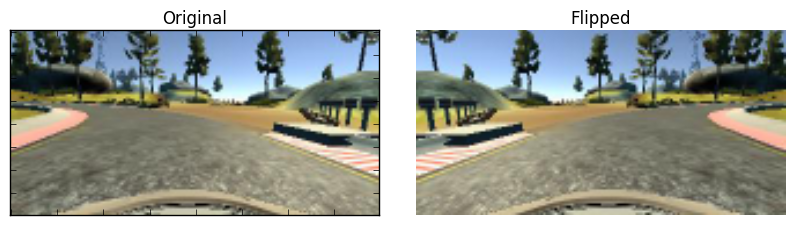

In [27]:
import matplotlib.gridspec as gridspec

img = preprocess_image(path, data_dir)

# Flip the image
img2 = cv2.flip(img, 1)

plt.figure(figsize = (10, 8))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.1, hspace=0.4) # set the spacing between axes. 
ax1 = plt.subplot(gs1[0])
plt.axis('on')
ax1.set_title('Original')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.imshow(img)
ax2 = plt.subplot(gs1[1])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_title('Flipped')
plt.imshow(img2)
plt.axis('off')
plt.show()

### Modify Image Brightness

It is important that the model behave and work under different lighting conditions. We will use Yadav's algorithm on randomly modifying the image brightness.

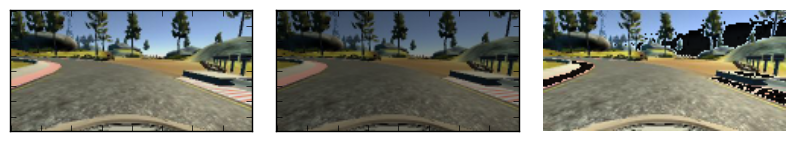

In [40]:
# Image Brightness Augmentation
# Vivek Yadav Blog post on Using Augmentation to mimic Human Driving
# https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.yh93soib0
def randomize_brightness(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    new_brightness = 0.25 + np.random.uniform()
    img[:, :, 2] = img[:, :, 2] * new_brightness
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

# Plot 3 random image brightness modifications to see the effects
plt.figure(figsize = (10, 8))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(wspace=0.1, hspace=0.2) # set the spacing between axes.
plt.axis('on')
for i in range(3):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    imgt = randomize_brightness(img)
    plt.imshow(imgt)
plt.axis('off')
plt.show()

### Image Translation

Image translation is another key augmentation especially to cover cases where the original training data had not driven to capture that view. It is important to adjust the steering angle appropriately to deal with that translation. that the model behave and work under different lighting conditions. We will use Yadav's algorithm on image translation.

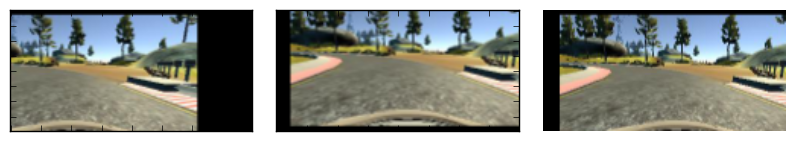

In [45]:
# Image Translation Augmentation
# Vivek Yadav Blog post on Using Augmentation to mimic Human Driving
# https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.yh93soib0
# Shift the camera horizontally as well as vertically.
# For horizontal shift make sure to add
def randomize_translation(image, steer):
    rows, cols, _ = image.shape
    trans_range = 100
    num_pixels = 10
    val_pixels = 0.4
    trans_x = trans_range * np.random.uniform() - trans_range / 2
    steer_angle = steer + trans_x / trans_range * 2 * val_pixels
    trans_y = num_pixels * np.random.uniform() - num_pixels / 2
    trans_M = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    image = cv2.warpAffine(image, trans_M, (cols, rows))
    return image, steer_angle

# Plot 3 random image brightness modifications to see the effects
plt.figure(figsize = (10, 8))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(wspace=0.1, hspace=0.2) # set the spacing between axes.
plt.axis('on')
for i in range(3):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    imgt, steer_ang = randomize_translation(img, steer)
    plt.imshow(imgt)
plt.axis('off')
plt.show()

### Put the image augmentation approaches together to transform the image

We write a transform_image route that applies translation, brightness modification and horizontal flip randomly to augment the image.

In [ ]:
# Augment image by adjusting brightness and added translation
# Adjust steering appropriately
def transform_image(image, steer):
    image, angle = randomize_translation(image, steer)
    image = randomize_brightness(image)
    steer_angle = angle

    # Horizontal Flip 50% of time randomly
    # Take are of turns, skip flipping for steering angles 0
    # Dont forget to fix the steering angle
    if random.random() >= .5 and abs(angle) > 0.1:
        image = cv2.flip(image, 1)
        steer_angle = -steer_angle

    return image, steer_angle


## Model 
### Description

We base our Deep Learning model on [Nvidia's Model](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) presented in the paper. The choice was based on the following
1. Nvidia had successfully applied this model to real-life driving by behavioral cloning.
2. Paul Heraty had successfully applied this model for this class assignment.
3. Started with something that works and then augment/modify it to get it to work.


![alt text](OurCNN.png)

Following the pattern of the Nividia model our model has (1 + 5)  Convolution Layers, followed by flattening, followed by three fully connected layers followed by the output layer. It of course starts off with a Normalization layer. 
An additional initial convolution layer with 1x1 filters to aid in color-selection was also applied.  
Just as in the Nvidia model for the five convolutional layers, the first 3 had filters of 5x5 and the last two had filters of size 3x3. The first three had strides of 2 and the last two had strides of 1.
Non-linearity was introduced by the use of activation layers (initially tanh and then ELU for quicker convergence). 
After each convolution layer and the Fully Connected layers we have added dropouts to avoid over-fitting. 
The optimizer chosen was Adam and the loss function to optimize over is the MSE (Mean Square Error).
This problmem is more of a regression rather than a classification problem where compute a continuous variable - a steering angle vs. classifying labels.

We present our model in tabular format below (from keras's summary output):


|Layer (type)                   |  Output Shape     |  Param #   |  Connected to         |
| ------------------------------|-------------------|------------|-----------------------|
|lambda_1 (Lambda)              | (None, 80, 160, 3)|  0         | lambda_input_1[0][0]  |   
|convolution2d_1 (Convolution2D)| (None, 80, 160, 3)|  12        | lambda_1[0][0]        | 
|convolution2d_2 (Convolution2D)| (None, 38, 78, 24)|  1824      | convolution2d_1[0][0] | 
|dropout_1 (Dropout)            | (None, 38, 78, 24)|  0         | convolution2d_2[0][0] |
|convolution2d_3 (Convolution2D)| (None, 17, 37, 36)|  21636     | dropout_1[0][0]       |   
|dropout_2 (Dropout)            | (None, 17, 37, 36)|  0         | convolution2d_3[0][0] |   
|convolution2d_4 (Convolution2D)| (None, 7, 17, 48) |  43248     | dropout_2[0][0]       |    
|dropout_3 (Dropout)            | (None, 7, 17, 48) |  0         | convolution2d_4[0][0] |
|convolution2d_5 (Convolution2D)| (None, 5, 15, 64) |  27712     | dropout_3[0][0]       |
|dropout_4 (Dropout)            | (None, 5, 15, 64) |  0         | convolution2d_5[0][0] |
|convolution2d_6 (Convolution2D)| (None, 3, 13, 64) |  36928     | dropout_4[0][0]       | 
|dropout_5 (Dropout)            | (None, 3, 13, 64) |  0         | convolution2d_6[0][0] |
|flatten_1 (Flatten)            | (None, 2496)      |  0         | dropout_5[0][0]       |
|dense_1 (Dense)                | (None, 100)       |  249700    | flatten_1[0][0]       | 
|dropout_6 (Dropout)            | (None, 100)       |  0         | dense_1[0][0]         | 
|dense_2 (Dense)                | (None, 50)        |  5050      | dropout_6[0][0]       |
|dropout_7 (Dropout)            | (None, 50)        |  0         | dense_2[0][0]         |
|dense_3 (Dense)                | (None, 10)        |  510       | dropout_7[0][0]       |  
|dropout_8 (Dropout)            | (None, 10)        |  0         | dense_3[0][0]         |  
|out (Dense)                    | (None, 1)         |  11        | dropout_8[0][0]       |

|Summary               | Count    |  
| ---------------------|----------|
|Total params          | 386,631  |
|Trainable params      | 386,631  |
|Non-trainable params  | 0        |

In [50]:
'''
Retuns the Nvidia based Model
Based on paper End-to-end Learning for Self-Driving Cars
http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
'''
def get_model():

    model = Sequential()

    # Normalization Layer
    image_shape = (RESIZED_IMG_HEIGHT, RESIZED_IMG_WIDTH, INPUT_CHANNELS)
    model.add(Lambda(lambda x: x / 127.5 - 0.5,
                     input_shape=(image_shape),
                     output_shape=(image_shape)))

    # First Convolution Layer with 1x1 filter for optimal color selection
    model.add(Convolution2D(3, 1, 1, border_mode="same"))

    # Convolution Layers with Dropout and Activation Layers
    # ELU Activation layers introduce non-linearity
    num_filters = [24, 36, 48, 64, 64]
    drop_out = 0.6
    filter_sizes = [(5, 5), (5, 5), (5, 5), (3, 3), (3, 3)]
    subsample_sizes = [(2, 2), (2, 2), (2, 2), (1, 1), (1, 1)]
    for conv_layer in range(len(num_filters)):
        model.add(Convolution2D(num_filters[conv_layer],
                                filter_sizes[conv_layer][0], filter_sizes[conv_layer][1],
                                border_mode='valid',
                                subsample=subsample_sizes[conv_layer],
                                activation='elu'))
        model.add(Dropout(drop_out))

    # Flatten the model
    model.add(Flatten())

    # Fully Connected Layers
    fc_neurons = [100, 50, 10]
    for fc_layer in range(len(fc_neurons)):
        model.add(Dense(fc_neurons[fc_layer], activation='elu'))
        model.add(Dropout(drop_out))

    # Final Output Layer
    model.add(Dense(1, activation='elu', name='out'))

    model.compile(optimizer=Adam(lr=0.001), loss="mse")

    return model

Here are the **modifications** we made to the original Nvidia model

1. *Input Size modified* : we reshaped the camera image to height=80, width=160. Nvidia used as its input shape 66x200
2. *Normalization* : We used the Comma.ai normalization (x/127.5 - 1)
3. *Added Color Selection Layer* (convolution2d_1) which uses a 3 output 1x1 filter. This was a recommendation from Yadav also. Instead of changing the color-space from RGB to YUV as was done by Nvidia, we will let the optimization algorithm, choose the optimal color-representation for the image.
4. *Added Dropout Layers* : We want to avoid over-fitting and hence use over Dropout layers after each of the Convolution layers and the Fully Connected layers.
5. *Activation Functions to introduce non-linearity* Taking cues from the [comma.ai model](https://github.com/commaai/research/blob/master/train_steering_model.py) we see they have leveraged the [ELU](https://github.com/commaai/research/blob/master/train_steering_model.py) for activation. It is supported as part of the Advanced Activation functions available in Keras. We also used this activation in our final output layer. ELUs allow negative values and tend to converge quicker than ReLU.Though ELUs and tansh performed similarly, we saw use of ELU activation in the output layer helped the model to successfully pass the second course successfully.
6. We used Adam Optimizer with Learning Rate 0.001 to optimize the model
7. *Number of Parameters* The total number of parameters for our model was 386631 as opposed to Nvidia's 250K parameters.

### Model Hyper Parameter Selection 

1. *Number of Epochs*
7 was a good choice. We saw the validation loss converge to 0.018.
2. *Training and Validation Set Sizes*
Our training size per-epoch was 60000 samples and the validation set was 5000
3. *Batch Size*
128 was the batch-size we fed in to the model generator
4. Learning Rate of Adam Optimizer
0.001 was better than 0.0001 which was too slow and took time to converge
5. Drop out - Set probability of drop to 0.6

### Implementation of Training and Validation
We used the keras libraries to define the model and also the training, optimization and validation operations. Keras libraries provide generators to read in sections of the training and validation data (without having to read in the complete set into memory all at once initially). We used keras's model.fit_generator function (as was guided in assignment instructions and also used in the Comma.ai model). We wrote our own simpler Generator functions to feed in the batches to the fit_generator function after spending considerable time trying to modify the Keras ImageDataGenerator and writing a fusion of NumPyArrayIterator and DirectoryIterator.

For center, left and right images, we randomly selected from amongst the three.

### Testing
Test results for the model were obtained by using the Simulator to successfully drive around multiple laps (at least 3) of Track 1 and finish Track 2 without going off track.

## Modifications to Drive.py
We increased the throttle in Drive.py to 0.32 instead of the constant 0.2. With 0.2 our car seemed to struggle to drive forward on Track 2